In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix

import joblib

Enter the path to the Excel file: categ_product_20250121.xlsx
Enter the main features to use (comma-separated): product_name_decli, summary, description
Enter the target feature (label): cat_name
Print info while exploring the file? (yes/no): yes
Enter the threshold for removing less populated categories (leave empty to skip): 
Multiple input features? We'll concatenate them into a superfeature. (yes/no): yes
Loading file...

Columns with no values were ['sku', 'id_supplier', 'sku_brand']. Deleted columns.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109918 entries, 0 to 109917
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  109918 non-null  int64  
 1   ean13               109918 non-null  int64  
 2   id_brand            108938 non-null  float64
 3   brand               109210 non-null  object 
 4   id_cat              109913 non-null  float64
 5   cat_name            1

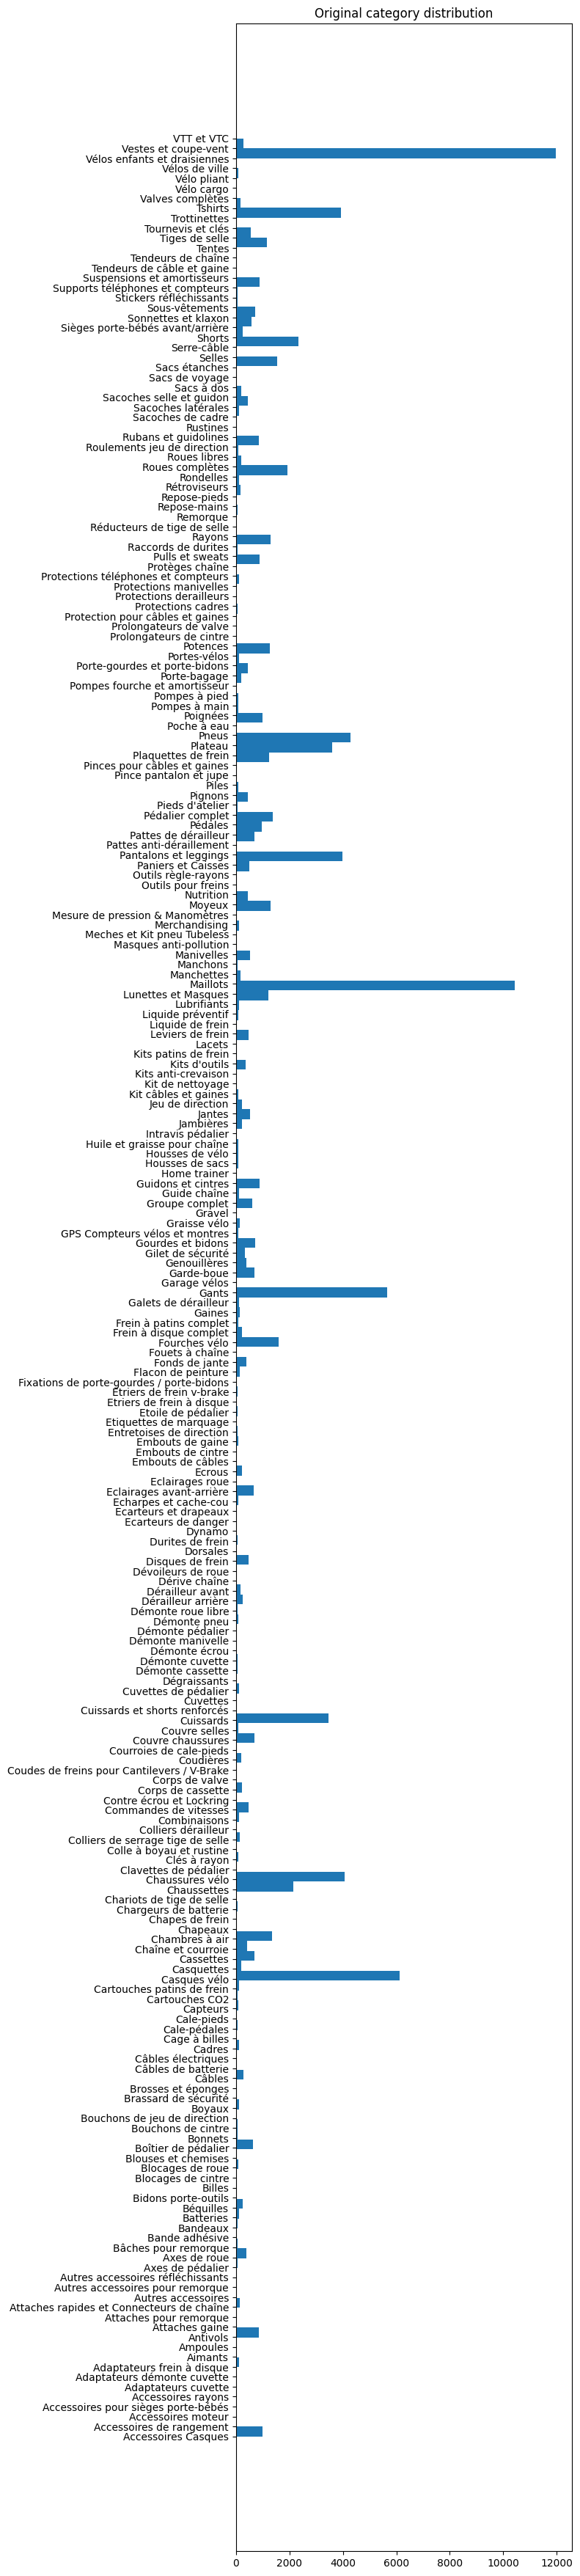

Model and vectorizer saved.
Accuracy: 0.9757085020242915

Classification Report:
                                             precision    recall  f1-score   support

                        Accessoires Casques       0.99      0.85      0.91       219
                   Accessoires de rangement       1.00      0.75      0.86         4
                         Accessoires rayons       1.00      0.12      0.22         8
                        Adaptateurs cuvette       0.00      0.00      0.00         6
                Adaptateurs démonte cuvette       0.00      0.00      0.00         2
                 Adaptateurs frein à disque       1.00      0.90      0.95        20
                                    Aimants       0.00      0.00      0.00         5
                                   Ampoules       1.00      0.67      0.80         6
                                   Antivols       0.99      1.00      1.00       160
                     Attaches pour remorque       0.00      0.00    

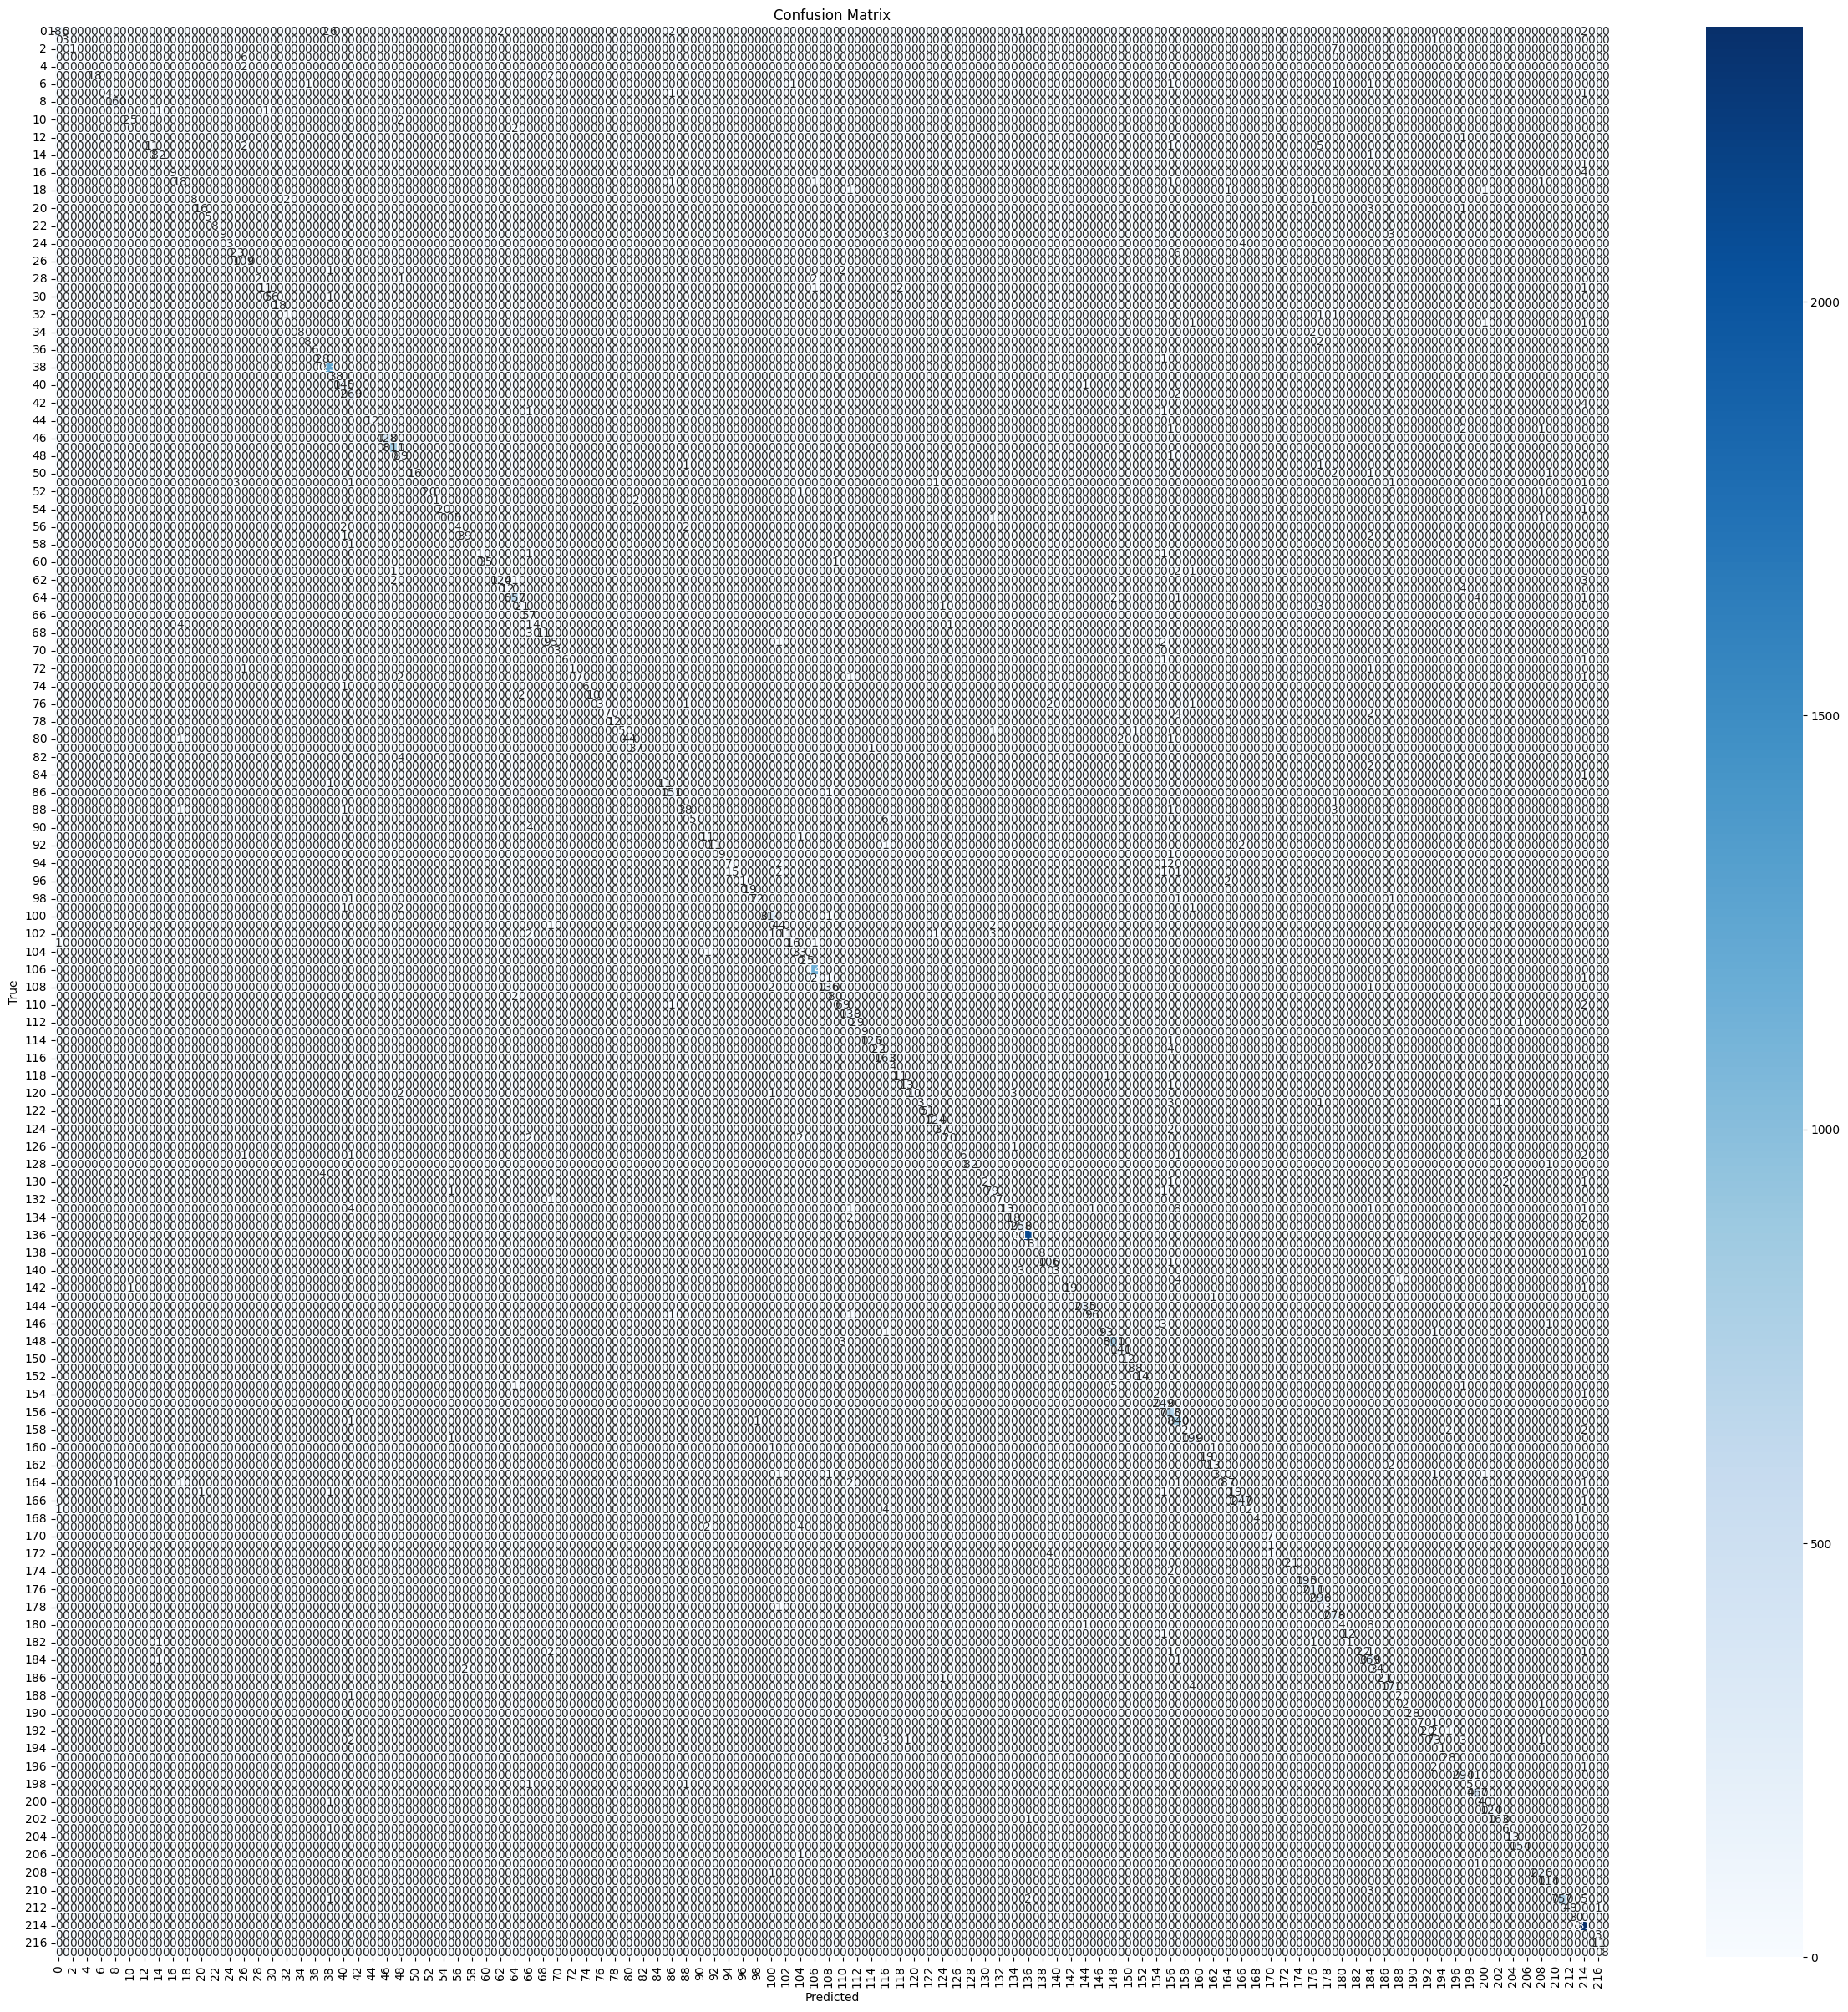


Predicted category for the example: L'incroyable manteau technique pour les jours de soleil., Vestes et coupe-vent

Pipeline completed. The processed DataFrame is available as 'products_df'.
The trained model is available as 'model' and the TF-IDF vectorizer as 'tfidf'.


In [40]:
def import_products(filepath, getinfo=False):
  """
  Imports product data from an Excel file and returns a DataFrame.
  """
  print("Loading file...\n")
  df = pd.read_excel(filepath)
  # Basic cleaning.
  empty = df.columns[df.isnull().all()].tolist()
  df = df.drop(columns=empty)
  missing = df.columns[df.isnull().any()].tolist()
  if getinfo:
    print(f"Columns with no values were {empty}. Deleted columns.\n")
    print(df.info())
    print(f"\nColumns with missing values are {missing}. They need further attention.")
  return df, missing

def study_features(df, main_features,concat=False):
  """
  Collects and cleans features of interest as told by the user.
  """
  for feature in main_features:
    print(f"\nStudying feature : {feature}")
    print(f"Missing rows count : {df['id'].where(df[feature].isna()).count()}")
    if input("Validate row deletion? It's needed for model training. (y/n)")=='y':
        df = df.where(df[feature].notna()).dropna(subset=[feature])
        df = df[df[feature].apply(lambda x: isinstance(x, str))]
        print(f"Duplicates count : {df['id'].where(df[feature].duplicated()).count()}")
        if input("Would you like to delete them? (y/n)")=='y':
            df.where(df[feature].notna()).drop_duplicates(subset=[feature])
  if concat:
    # Bonus: concatenate the selected features into a new column 'allfeatures'
    print("\nConcatenating features...")
    df['allfeatures'] = df[main_features].fillna('').astype(str).agg(' '.join, axis=1)
    df = df.drop(columns=main_features)
    # Drop only rows with no info at all
    df = df.dropna(subset=['allfeatures'])
    main_features = ['allfeatures']
  return df, main_features


def study_labels(df, target_feature, threshold=None):
  """
  Explores label repartition.
  """
  print(f"\nLabels found in column {target_feature}")
  assert df['id'].where(df[target_feature].isna()).count() == 0
  possible_labels = df[target_feature].unique()
  print(f"{len(possible_labels)} possibilities.")
  plt.subplots(figsize=(8, 35))
  plt.hist(df[target_feature],orientation='horizontal',bins=len(possible_labels))
  plt.tight_layout()
  plt.title('Original category distribution')
  plt.show()
  if threshold:
    # Deleting less populated categories, focus on main ones. We would need another classifier for these (to be continued).
    counts = df[target_feature].value_counts(normalize=True)
    to_remove = counts[counts < threshold].index
    df = df[~df[target_feature].isin(to_remove)]
    print(f"New category count : {len(df[target_feature].unique())}")
    df[target_feature].value_counts().plot(title='New category distribution', kind='bar', figsize=(12,5))
    possible_labels = df[target_feature].unique()
  return df, possible_labels


def train_model(df,main_features,target_feature):
  """
  Train a LogisticRegression model.
  TBC for other types of models.
  """
  X = df[main_features]
  y = df[target_feature]
  tfidf = TfidfVectorizer()
  X_tfidf = tfidf.fit_transform(X)
  X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
  # Train a classification model (Logistic Regression)
  model = LogisticRegression(max_iter=1000)
  model.fit(X_train, y_train)
  # Save the model and vectorizer
  joblib.dump(model, 'logistic_regression_model.pkl')
  joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
  print("Model and vectorizer saved.")
  return X_train, X_test, y_train, y_test, model, tfidf


def report_evaluate(model, tfidf, X_test, y_test):
  """
  Reporting on model performance.
  """
  # Predict on the test set and score
  y_pred = model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  print(f"Accuracy: {accuracy}")
  print("\nClassification Report:")
  print(classification_report(y_test, y_pred))
  # Confusion Matrix
  cm = confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(30, 30))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.show()
  # Example
  example = "L'incroyable manteau technique pour les jours de soleil."
  example_tfidf = tfidf.transform([example])
  predicted_category = model.predict(example_tfidf)
  print(f"\nPredicted category for the example: {example}, {predicted_category[0]}")


def use_in_prediction(model, tfidf, given_X):
  # Predict on the test set and score
  y_pred = model.predict(given_X)
  return y_pred


def full_pipeline(csv_filepath, main_features, target_feature, getinfo=False, threshold=None, concat_feats=False, dev=True):
  """
  Load a file (csv_filepath), clean it.
  Explore main features (main_features) and target repartition (target_feature),
  train a model and evaluate it.
  getinfo: bool, whether to print info while exploring the file or not
  concat_feats: bool, whether to concatenate the selected features into a new column 'allfeatures'
  threshold: float, if not None, deletes less populated categories to focus on main ones.
  """

  # Load the saved model and TF-IDF vectorizer
  try:
    model = joblib.load('logistic_regression_model.pkl')
    tfidf = joblib.load('tfidf_vectorizer.pkl')
  except FileNotFoundError:
    print("Error: Model and TF-IDF vectorizer files not found.")
    exit()
  # Go through the full pipeline: cleaning, exploring, training and evaluating
  products_df, products_missing = import_products(csv_filepath,getinfo)
  products_df, new_features = study_features(products_df, main_features, concat=concat_feats)
  products_df, possible_labels = study_labels(products_df, target_feature, threshold)
  X_train, X_test, y_train, y_test, model, tfidf = train_model(products_df, new_features[0], target_feature)
  if dev:
    report_evaluate(model, tfidf, X_test, y_test)
  else:
    # Wrong thing to do, I should define X_test earlier depending on whether the dataframe has a label column or not.
    # But time's up :)
    use_in_prediction(model, tfidf, X_test)
  # Save csv
  products_df.to_csv('products_df.csv', index=False)
  return products_df, model, tfidf

def main():
  """
  Interactive pipeline.
  """
  filepath = input("Enter the path to the Excel file: ")
  features_input = input("Enter the main features to use (comma-separated): ")
  main_features = [f.strip() for f in features_input.split(',')]
  target_feature = input("Enter the target feature (label): ")
  getinfo_input = input("Print info while exploring the file? (yes/no): ").lower()
  getinfo = getinfo_input == 'yes'
  threshold_input = input("Enter the threshold for removing less populated categories (leave empty to skip): ")
  threshold = float(threshold_input) if threshold_input else None
  concat_input = input("Multiple input features? We'll concatenate them into a superfeature. (yes/no): ").lower()
  concat_feats = concat_input == 'yes'

  products_df_cleaned, model, tfidf = full_pipeline(filepath, main_features, target_feature, getinfo, threshold, concat_feats)
  print("\nPipeline completed. The processed DataFrame is available as 'products_df'.")
  print("The trained model is available as 'model' and the TF-IDF vectorizer as 'tfidf'.")

if __name__ == "__main__":
  main()